In [14]:
user_input = input("Has the tweets dataset been processed? y or n ").strip().lower()

# Stock Market Sentiment Analysis

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Collection](#Data-Collection)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Modeling](#Modeling)
    - [Logistic Regression](#Logistic-Regression)
    - [Support Vector Machine](#Support-Vector-Machine)
6. [Model Evaluation](#Model-Evaluation)
7. [Conclusion](#Conclusion)

## Introduction
In this project, we will perform sentiment analysis on financial news articles to predict the sentiment of the stock market. We will use logistic regression and support vector machine (SVM) for classification and evaluate the models using accuracy, precision, and recall metrics.

## Data Collection
We will collect financial news articles from X (formerly known as Twitter) using the Tweepy library.

In [15]:
# Install necessary libraries
# !pip install tweepy pandas scikit-learn nltk

In [16]:
# Install necessary libraries
# %pip install tweepy

# Import necessary libraries
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from library.sb_utils import save_file

%matplotlib inline


In [17]:
path = r"C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\data\raw\training.1600000.processed.noemoticon.csv"
unprocessed_tweets_df = pd.read_csv(path, encoding='latin', header=None)

In [18]:
unprocessed_tweets_df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
unprocessed_tweets_df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [19]:
unprocessed_tweets_df['sentiment'].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

In [20]:
# replace 4 with 1
unprocessed_tweets_df['sentiment'] = unprocessed_tweets_df['sentiment'].replace({4:1})

In [21]:

unprocessed_tweets_df['sentiment'].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

## Data Preprocessing
We will clean and tokenize the text data.

In [22]:
# Check if 'punkt' is already downloaded
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Download NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Function to clean and tokenize text data
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    # Join tokens back into a single string
    text = ' '.join(tokens)
    return text

## Exploratory Data Analysis
We will explore the data to understand its structure and distribution.

In [24]:
if user_input == 'n':
    # Apply preprocessing to the text data
    unprocessed_tweets_df['cleaned_text'] = unprocessed_tweets_df['text'].apply(preprocess_text)

    # Display the first few rows of the dataset
    unprocessed_tweets_df.head()

    # Save the preprocessed dataset
    save_file(unprocessed_tweets_df, 'processed_tweets_df.csv')
else:
    processed_tweets_df = pd.read_csv(r'C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\data\raw\preprocessed_tweets_df.csv')
    print(processed_tweets_df.head())

   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  \
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1    scotthamilton  is upset that he can't update his Facebook by ...   
2         mattycus  @Kenichan I dived many times for the ball. Man...   
3          ElleCTF    my whole body feels itchy and like its on fire    
4           Karoli  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0  switchfoot Awww bummer shoulda got David Carr ...  
1  upset update Facebook texting might cry

## Modeling
We will use logistic regression and support vector machine (SVM) for classification.

In [25]:
# Fill NaN values with an empty string
processed_tweets_df['cleaned_text'] = processed_tweets_df['cleaned_text'].fillna('')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(processed_tweets_df['cleaned_text'], processed_tweets_df['sentiment'], test_size=0.25, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Logistic Regression

In [26]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000)),  # Convert text to TF-IDF features
    ('logreg', LogisticRegression(solver='saga', max_iter=2000, tol=1e-3, class_weight='balanced', n_jobs=-1))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'logreg__C': [0.01, 0.1, 1],  # Regularization strengths
    'logreg__solver': ['saga', 'liblinear']  # Test different solvers
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

# Fit the pipeline on the training data
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_logreg = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test data
test_accuracy = best_logreg.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Best Parameters: {'logreg__C': 1, 'logreg__solver': 'saga'}
Best Cross-Validation Accuracy: 0.7740758333333333
Test Accuracy: 0.77362


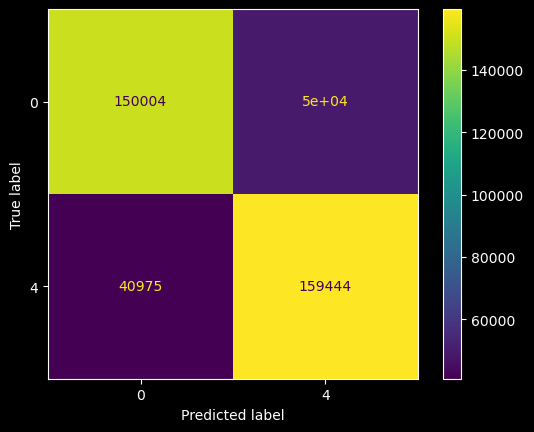

In [27]:
# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_logreg, X_test, y_test)

c:\Users\adame\anaconda3_\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


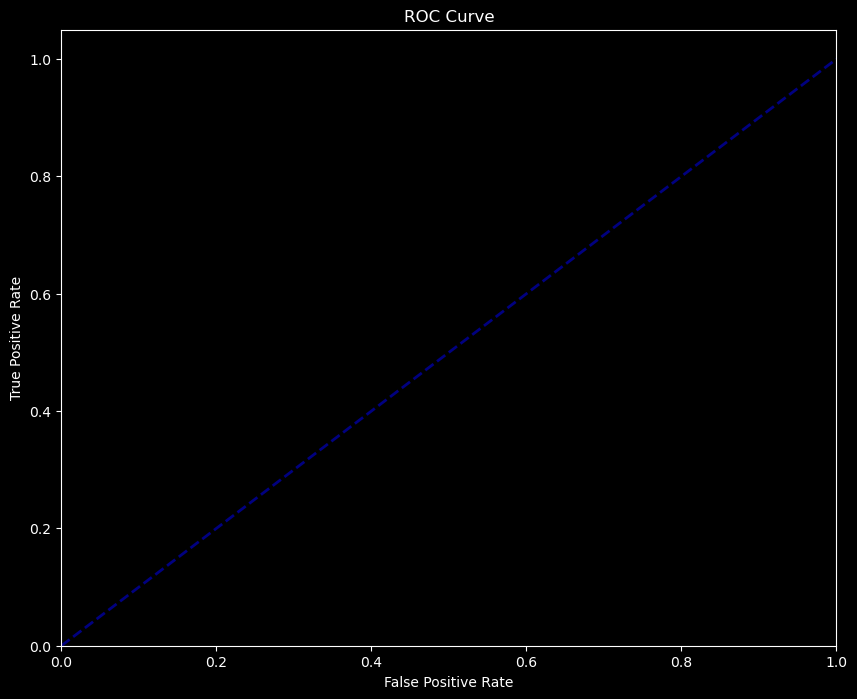

In [32]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, best_logreg.predict_proba(X_test)[:, 1], pos_label=1)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

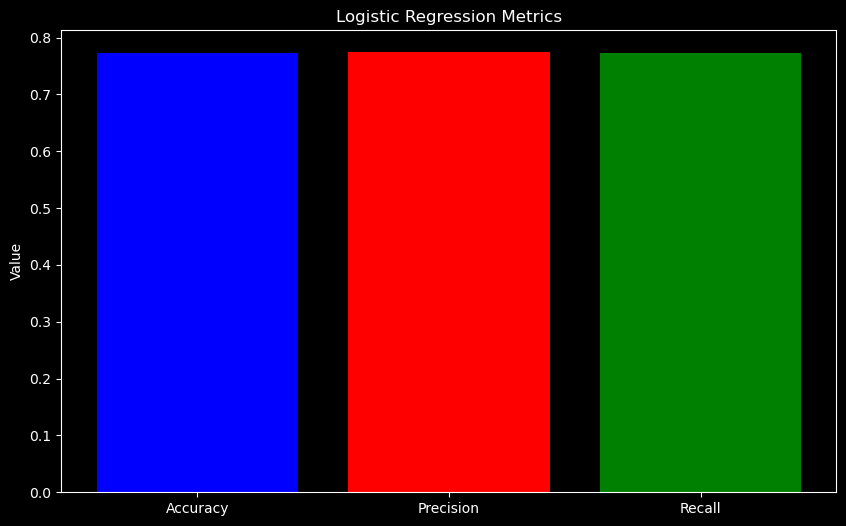

In [34]:
# Predict using the best logistic regression model
y_pred_logreg = best_logreg.predict(X_test)

# create a bar chart for metrics like precision, recall, and accuracy
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy_score(y_test, y_pred_logreg), 
          precision_score(y_test, y_pred_logreg, average='weighted'), 
          recall_score(y_test, y_pred_logreg, average='weighted')]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'red', 'green'])
plt.ylabel('Value')
plt.title('Logistic Regression Metrics')
plt.show()

## Visualize the Results

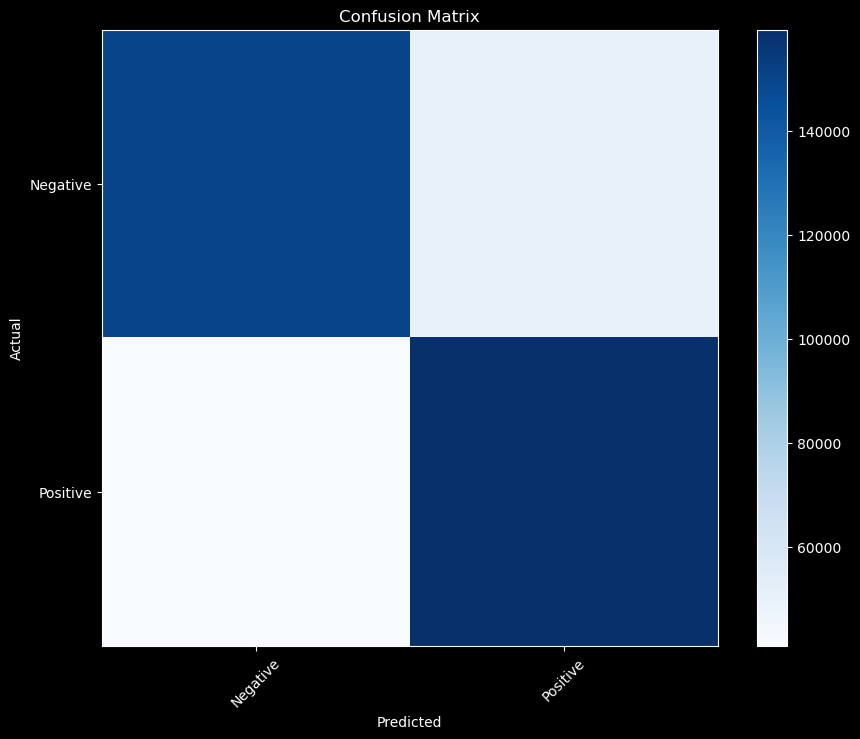

In [35]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues', interpolation='None') 
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'], rotation=45)
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Error Analysis
    We will analyze the errors made by the model to understand where it is making mistakes.

In [36]:
# identify misclassified samples
misclassified_indices = np.where(y_test != y_pred_logreg)[0]

# Display some misclassified samples
for index in misclassified_indices[:5]:
    print(X_test.iloc[index])
    print('True label:', y_test.iloc[index])
    print('Predicted label:', y_pred_logreg[index])
    print()

chrishasboobs AHHH HOPE OK
True label: 0
Predicted label: 4

misstoriblack cool tweet apps razr
True label: 0
Predicted label: 4

TiannaChaos know family drama lame hey next time u hang kim n u guys like sleepover whatever ill call u
True label: 0
Predicted label: 4

upper airways problem
True label: 0
Predicted label: 4

Going miss Pastor sermon Faith
True label: 0
Predicted label: 4



In [37]:
len(misclassified_indices)
total = len(misclassified_indices) / len(y_test)
print(f'Total misclassified samples: {total * 100:.2f}%')

Total misclassified samples: 22.64%


## Conclusion and Future Work
    Summarize the findings and discuss the performance of the models. Suggest future work to improve the models.
   

## Conclusion
Summarize the findings and discuss the performance of the models.

In [38]:
model_path = r'C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\models'

# save the model

save_file(best_logreg, 'best_svm_model.pkl', model_path)

# save the dataframe
save_file(unprocessed_tweets_df, 'unprocessed_tweets_df.pkl', model_path)

# save the vectorizer
save_file(vectorizer, 'tfidf_vectorizer.pkl', model_path)

# save the data to csv
data_path = r'C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\data\processed'
save_file(unprocessed_tweets_df, 'processed_tweets_df.csv', data_path)

A file already exists with this name.

Writing file.  "C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\models\best_svm_model.pkl"
A file already exists with this name.

Writing file.  "C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\models\unprocessed_tweets_df.pkl"
A file already exists with this name.

Writing file.  "C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\models\tfidf_vectorizer.pkl"
A file already exists with this name.

Writing file.  "C:\Users\adame\OneDrive\Desktop\python_scripts\data_projects\x_sentiment_analysis\x_sentiment_analysis\data\processed\processed_tweets_df.csv"
